# Titanic Classification Competition
- I finished in the top 7% with this simple run-through for this competition, you take it from here and improve upon it!

In [143]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statistics as stats
import missingno as msno

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import os
#this allows us to see all of our columns or rows in jupyter notebook
pd.set_option('display.max_columns', None)

#lines below let allow multiple results from a line of code to be shown e.g. df.head() + df.columns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

__We need to start by importing the data, we will change our working directory to the folder where our data sets are held__

In [2]:
os.getcwd()

'C:\\Users\\Sam Cannon\\Desktop\\Python\\Data Competitions'

In [3]:
os.chdir('C:\\Users\\Sam Cannon\\Desktop\\Python\\Data Sets')

In [4]:
train = pd.read_csv('titanic_train.csv')

__Lets take a look at the head of our data to make sure that everything looks good, then we will import our test set__

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test = pd.read_csv('titanic_test.csv')

In [7]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


__Now, lets merge the training and test data and add train/test flag columns so that we can clean it all together__
- this saves us some time rather than cleaning the test set separately

In [8]:
train['trainflag'] = 0
test['testflag'] = 1
data = pd.concat([train, test], sort=True)

In [9]:
#did it work?
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,testflag,trainflag
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,NaN,0.0
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,NaN,0.0
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,NaN,0.0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,NaN,0.0
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,NaN,0.0


__Now that we have concatenated our data, we can start looking at characteristics of the data, lets look at missingness first and then look at correlations between features__

In [10]:
data.isna().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
testflag        891
trainflag       418
dtype: int64

__This heatmap tells us whether our missingness within features correlates with one another, with 1 meaning that the features are present together and -1 meaning that when one feature is missing then the other one is too__
- our features do not seem to correlate with respect to missingness very much

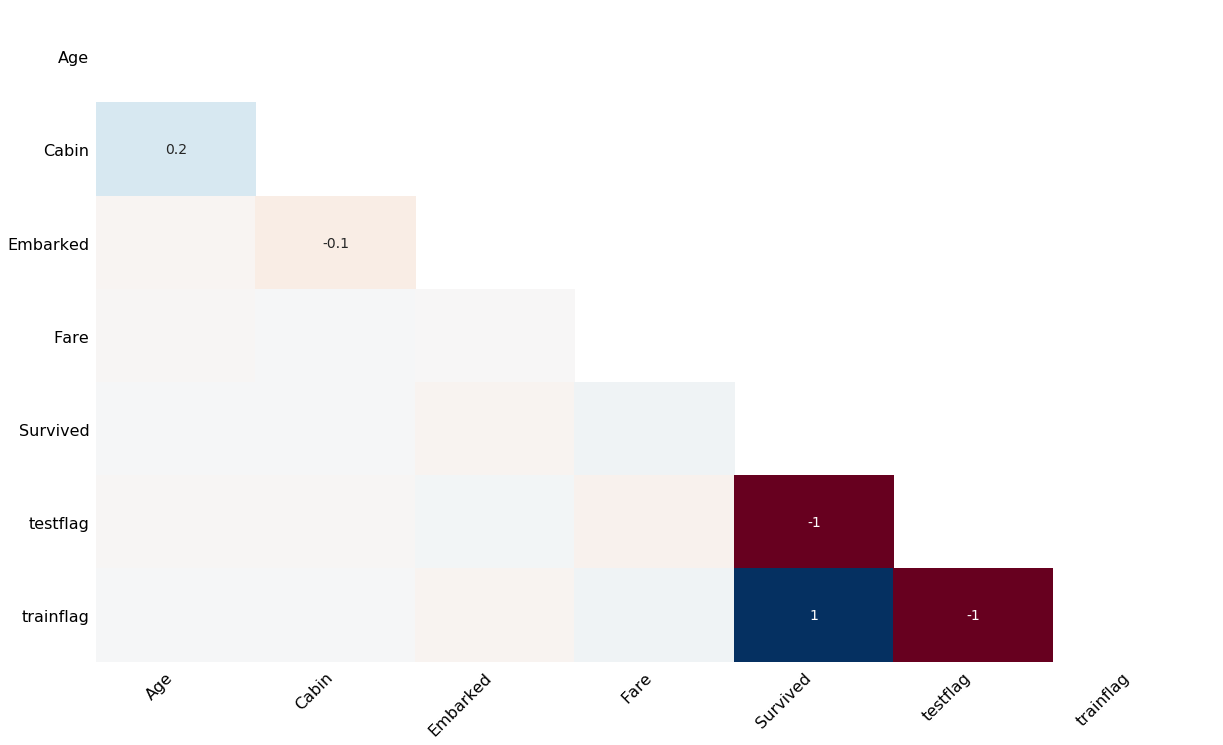

In [11]:
msno.heatmap(data)

__Now, lets look at a classic correlation table to see how the features correlate with the labels__

Before we do this, we need to transform our Male/Female column to numeric, since this is a string column now, but I am sure that sex played a role in the survival of passengers

In [12]:
SexMap = {'male':0, 'female':1}
data['Sex'].replace(SexMap, inplace=True)
data['Sex'].head()

0    0
1    1
2    1
3    1
4    0
Name: Sex, dtype: int64

In [13]:
data['Sex'] = pd.to_numeric(data['Sex'])

In [14]:
data.dtypes

Age            float64
Cabin           object
Embarked        object
Fare           float64
Name            object
Parch            int64
PassengerId      int64
Pclass           int64
Sex              int64
SibSp            int64
Survived       float64
Ticket          object
testflag       float64
trainflag      float64
dtype: object

__Now, lets see a correlation heatmap__

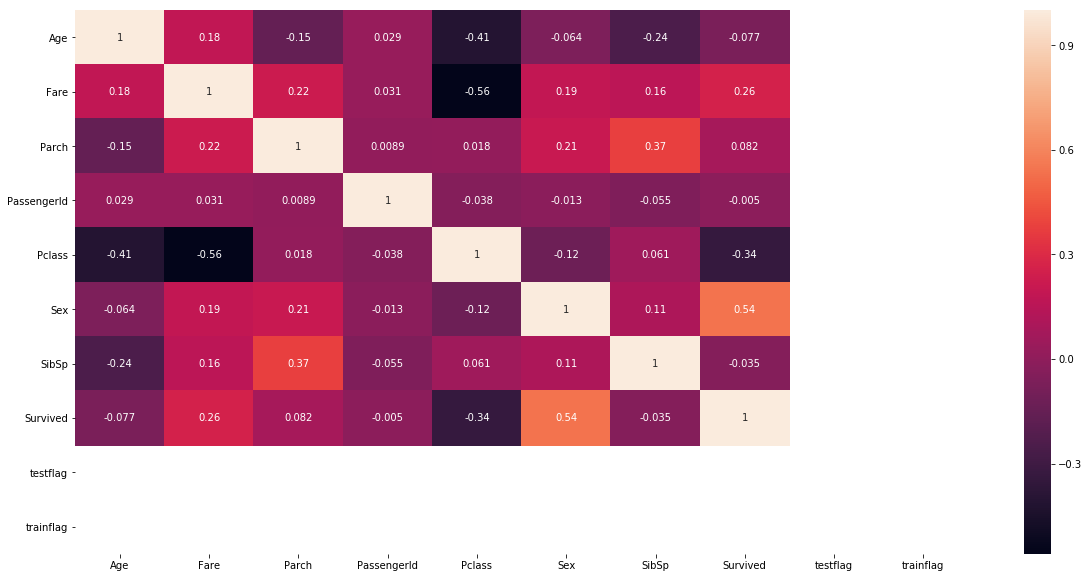

In [15]:
corr = data.corr()
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corr, annot=True)

It appears as though Sex correlates strongly with our labels, those who survived, fare and Pclass are the next highest correlates, I wonder if we can combine any of these to create new features?

# Data Cleaning
- lets get rid of the missing values

In [16]:
data.isna().sum()
data.shape

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
testflag        891
trainflag       418
dtype: int64

(1309, 14)

Looks like the cabin feature is missing most of its values, lets delete this feature

In [17]:
data.drop('Cabin', axis=1, inplace=True)

Now we should look at the age feature to see if we can impute values for this

In [18]:
np.mean(data.Age)

29.881137667304014

In [19]:
#this version of np.median ignores the nan values in this feature
np.nanmedian(data.Age)

28.0

Lets impute the median values for age by Sex, this is meant to get a more accurate picture of how old these missing individuals actually were, and Sex seems to be a logical identifier that we can group them by, not sure if any other feature  would be better...

In [28]:
data['Age'] = data.groupby('Sex').Age.transform(lambda x: x.replace(np.nan, x.median()))

In [29]:
#now lets check na
data.isna().sum()

Age              0
Embarked         2
Fare             1
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
Ticket           0
testflag       891
trainflag      418
dtype: int64

Our only missing values remaining are Embarked and Fare, lets look at these

In [31]:
data['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

It looks like 'S' is the most common, lets replace our missing value with this

In [32]:
data['Embarked'].replace(np.nan, 'S', inplace=True)

In [33]:
data.isna().sum()

Age              0
Embarked         0
Fare             1
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
Ticket           0
testflag       891
trainflag      418
dtype: int64

Now, lets look at Fare

In [34]:
data['Fare'].head(20)

0      7.2500
1     71.2833
2      7.9250
3     53.1000
4      8.0500
5      8.4583
6     51.8625
7     21.0750
8     11.1333
9     30.0708
10    16.7000
11    26.5500
12     8.0500
13    31.2750
14     7.8542
15    16.0000
16    29.1250
17    13.0000
18    18.0000
19     7.2250
Name: Fare, dtype: float64

In [39]:
data['Fare'].groupby(data['Pclass']).mean()

Pclass
1    87.508992
2    21.179196
3    13.302889
Name: Fare, dtype: float64

In [35]:
#lets replace the missing value in Fare by the average for its class
data['Fare'] = data.groupby('Pclass').Fare.transform(lambda x: x.replace(np.nan, x.mean()))

In [36]:
data.isna().sum()

Age              0
Embarked         0
Fare             0
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
Ticket           0
testflag       891
trainflag      418
dtype: int64

__OK now all of our data is clean, lets start modeling__

# Modeling

In [44]:
#dummy code for categorical string features, code the entire dataset, drop the Name feature first since it offers no 
#value for our predictions
data.drop('Name', axis=1, inplace=True)
data_dummies = pd.get_dummies(data)

In [48]:
#split the dataset into training and test sets, then drop the test and train flags
train = data_dummies[data_dummies['trainflag'] == 0]
train.drop('trainflag', axis=1, inplace=True)
test = data_dummies[data_dummies['testflag'] == 1]
test.drop('testflag', axis=1, inplace=True)

C:\Users\Sam Cannon\Python\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [53]:
#drop test and train flags again
train.drop('testflag', axis=1, inplace=True)
test.drop('trainflag', axis=1, inplace=True)

In [56]:
#drop our label column from our test set
test.drop('Survived', axis=1, inplace=True)

In [98]:
#check our shapes to see if they are right, test set should be one feature short of our training set
train.shape
test.shape

(891, 940)

(418, 939)

In [151]:
#split data into training and test sets
label = train['Survived']
features = train.drop('Survived', axis=1)

# Splitting the observations into a training and a testing set for the holdout method

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.30, random_state=46)


In [153]:
# Min-max scaling for neural nets and SVMs
from sklearn import preprocessing
X_train_norm = preprocessing.normalize(X_train, norm='max', axis=0)  # Normalizing across columns
X_test_norm = preprocessing.normalize(X_test, norm='max', axis=0)  # Normalizing across columns

__We are going to look at several classification algorithms and print our reports to see their initial performance__

In [152]:
# Logistic Regression - http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression(C=1.0, penalty='l1', n_jobs=-1)
lm.fit(X_train, y_train)
print(lm.score(X_train, y_train))
X_test_predictions = lm.predict(X_test)
print(classification_report(y_test, X_test_predictions))

C:\Users\Sam Cannon\Python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sam Cannon\Python\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l1', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

0.8105939004815409
              precision    recall  f1-score   support

         0.0       0.84      0.89      0.86       160
         1.0       0.82      0.74      0.78       108

   micro avg       0.83      0.83      0.83       268
   macro avg       0.83      0.82      0.82       268
weighted avg       0.83      0.83      0.83       268



In [148]:
# Decision Tree - http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1)
dt.fit(X_train, y_train)
print(dt.score(X_test, y_test))
pred = dt.predict(X_test)
print(classification_report(y_test, pred))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

0.835820895522388
              precision    recall  f1-score   support

         0.0       0.86      0.87      0.86       160
         1.0       0.80      0.79      0.79       108

   micro avg       0.84      0.84      0.84       268
   macro avg       0.83      0.83      0.83       268
weighted avg       0.84      0.84      0.84       268



In [150]:
# k-NN - http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))
pred = knn.predict(X_test)
print(classification_report(y_test, pred))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
           weights='uniform')

0.667910447761194
              precision    recall  f1-score   support

         0.0       0.66      0.91      0.77       160
         1.0       0.69      0.31      0.43       108

   micro avg       0.67      0.67      0.67       268
   macro avg       0.68      0.61      0.60       268
weighted avg       0.67      0.67      0.63       268



In [168]:
# Random Forest - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
#I played around with tree numbers here
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=700, max_depth=None, n_jobs=-1, random_state = 87)
rf.fit(X_train, y_train)
print(rf.score(X_test, y_test))
pred = rf.predict(X_test)
print(classification_report(y_test, pred))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=-1,
            oob_score=False, random_state=87, verbose=0, warm_start=False)

0.8395522388059702
              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87       160
         1.0       0.82      0.77      0.79       108

   micro avg       0.84      0.84      0.84       268
   macro avg       0.84      0.83      0.83       268
weighted avg       0.84      0.84      0.84       268



In [165]:
# Gradient Boosted Tree - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
# I played around with tree numbers here
from sklearn.ensemble import GradientBoostingClassifier
gbt = GradientBoostingClassifier(n_estimators=1220, learning_rate=0.1, max_depth=3, random_state = 46)
gbt.fit(X_train, y_train)
print(gbt.score(X_test, y_test))
pred = gbt.predict(X_test)
print(classification_report(y_test, pred))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1220,
              n_iter_no_change=None, presort='auto', random_state=46,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

0.8432835820895522
              precision    recall  f1-score   support

         0.0       0.86      0.89      0.87       160
         1.0       0.82      0.78      0.80       108

   micro avg       0.84      0.84      0.84       268
   macro avg       0.84      0.83      0.84       268
weighted avg       0.84      0.84      0.84       268



In [170]:
# MLP Neural Network - http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=0.0001,
                      learning_rate='constant', learning_rate_init=0.001)
nn.fit(X_train_norm, y_train)
print(nn.score(X_test_norm, y_test))
pred = nn.predict(X_test_norm)
print(classification_report(y_test, pred))

C:\Users\Sam Cannon\Python\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

0.835820895522388
              precision    recall  f1-score   support

         0.0       0.86      0.87      0.86       160
         1.0       0.80      0.79      0.79       108

   micro avg       0.84      0.84      0.84       268
   macro avg       0.83      0.83      0.83       268
weighted avg       0.84      0.84      0.84       268



In [172]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1, 
                         n_estimators=50, random_state=None)
abc.fit(X_train, y_train)
print(abc.score(X_test, y_test))
pred = abc.predict(X_test)
print(classification_report(y_test, pred))

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=50, random_state=None)

0.8171641791044776
              precision    recall  f1-score   support

         0.0       0.82      0.89      0.85       160
         1.0       0.81      0.71      0.76       108

   micro avg       0.82      0.82      0.82       268
   macro avg       0.82      0.80      0.81       268
weighted avg       0.82      0.82      0.81       268



# Stacking Classifiers
- here we are going to stack several classifiers and take a 'hard' vote between them all using the VotingClassifier

In [186]:
from sklearn.ensemble import VotingClassifier
model1 = abc
model2 = rf
model3 = nn
model4 = gbt
model5 = dt
model6 = lm
model = VotingClassifier(estimators=[('abc', model1), ('rf', model2), ('gbt', model4), ('dt', model5)], voting='hard')
model.fit(X_train,y_train)
model.score(X_test,y_test)

VotingClassifier(estimators=[('abc', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=50, random_state=None)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

0.8507462686567164

__Send data to prediction set for submission__

In [184]:
pd.DataFrame(model.predict(test)).to_csv('new.csv')